### Librerías

In [113]:
import io
import os
import sys
import pickle
import tarfile
import urllib

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.linear_model import LogisticRegression
import torch
import torchvision.transforms.functional as TF
from tqdm import tqdm
from pathlib import Path
import cv2

### Cargando imágenes

In [109]:
# La máscara generada (show_mask) pintada sobre la imagen.
# Los puntos positivos/negativos que das como guía (show_points).
# La caja delimitadora (show_box).

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2)) 

In [172]:
image = cv2.imread('jpg_images/NAY98-21-A.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

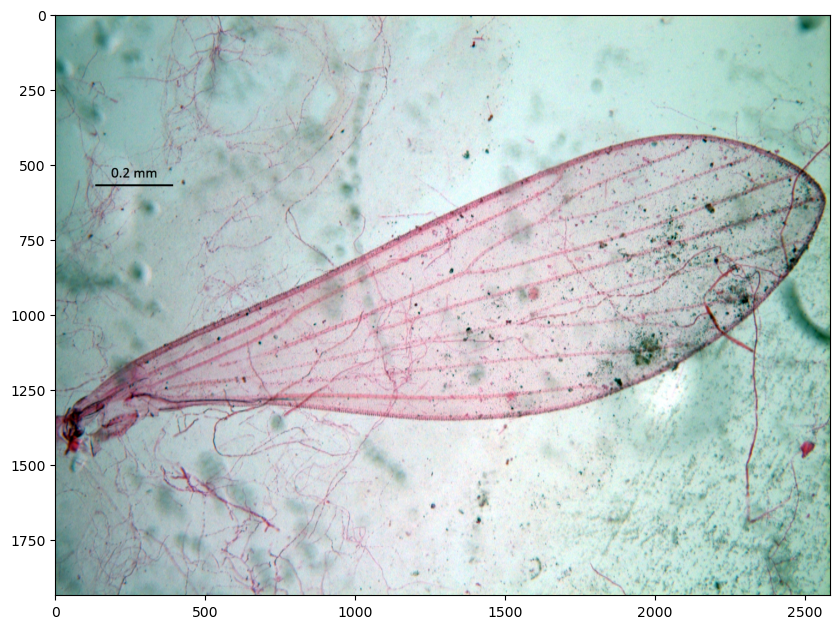

In [174]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

### Cargando el modelo

In [176]:
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "model/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [178]:
predictor.set_image(image)

In [184]:
input_point = np.array([[1250, 1100]])
input_label = np.array([1])

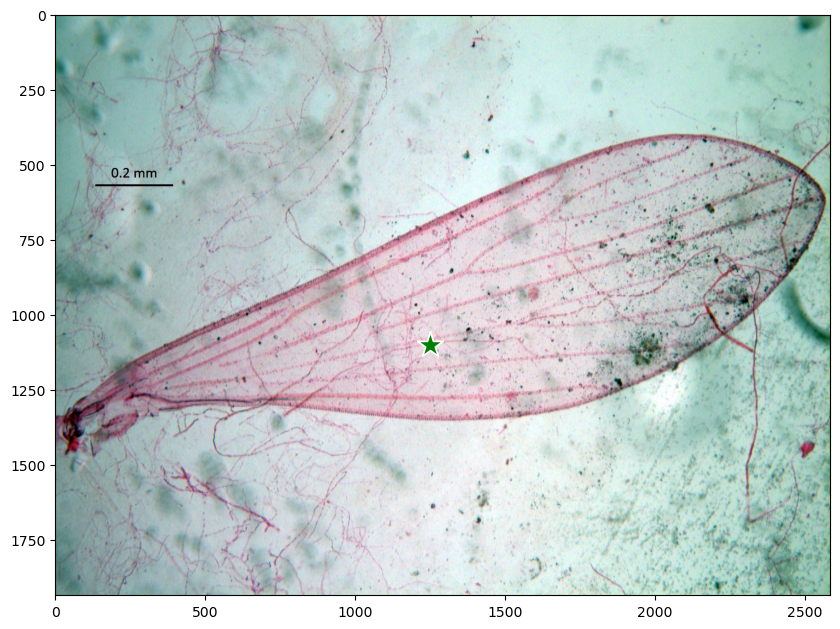

In [186]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [188]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

In [190]:
masks.shape

(3, 1936, 2584)

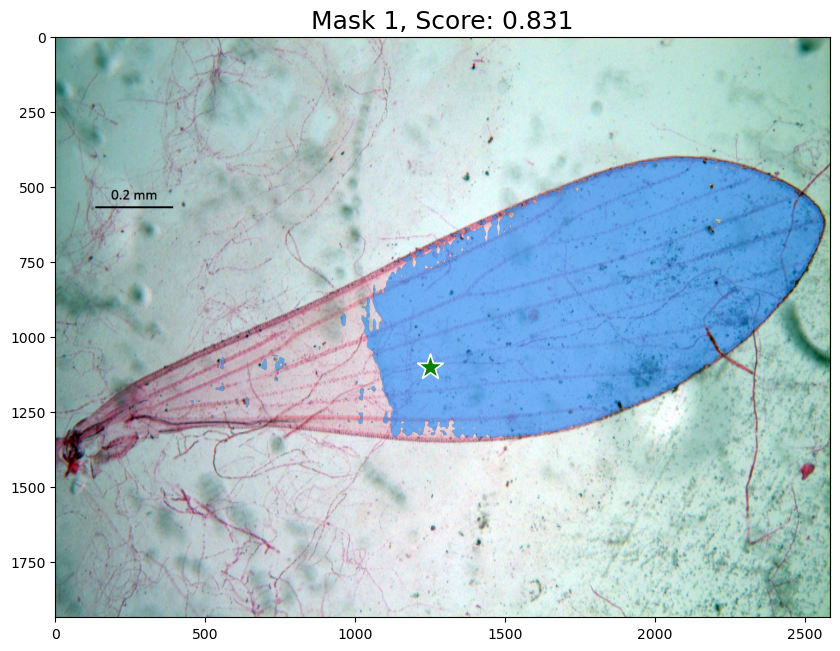

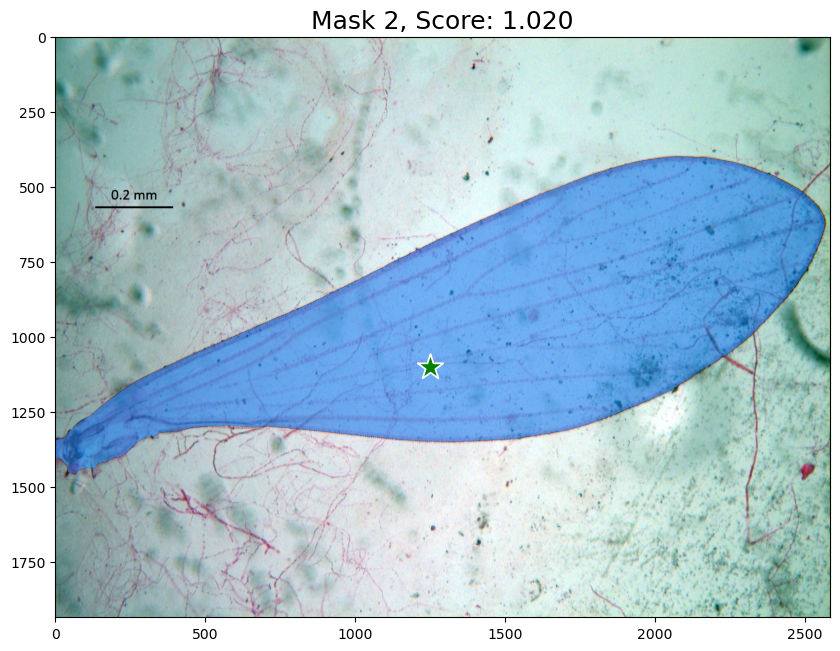

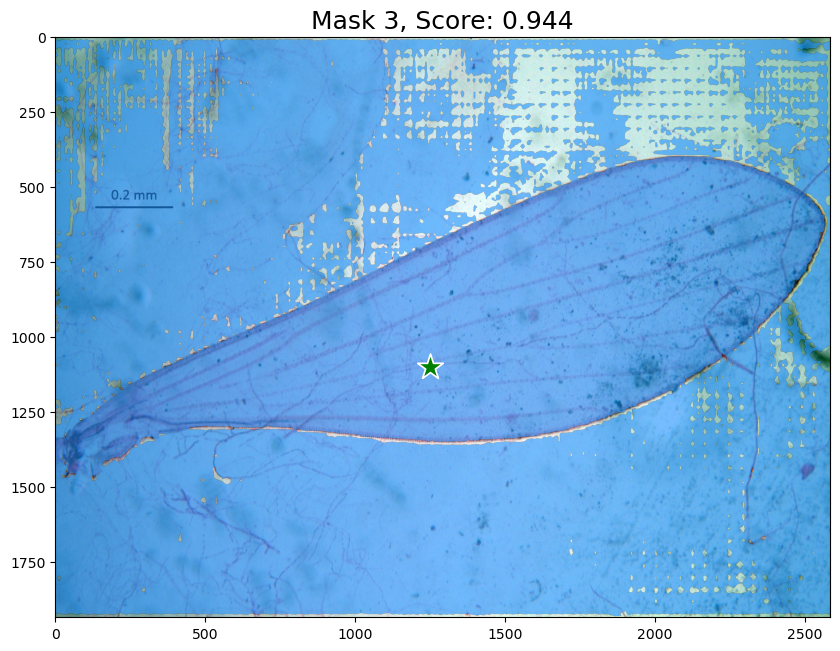

In [194]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.show()  